# Dogs in Vienna: Sample Open Data Analysis Script
This is a sample script showing how an open data datasets can be analysed and demonstrated using [Jupiter Notebooks](http://jupyter.org). Similar examples can be found on [Kaggle web-site](https://www.kaggle.com/kernels).

## Acknowledgments
1. Inspired by [Detail Analysis of various Hospital factors](https://www.kaggle.com/nirajvermafcb/d/cms/hospital-general-information/detail-analysis-of-various-hospital-factors)

## Open Data Story

In [13]:
# Load libraries
import pandas as pd # CSV file processing
import numpy as np # vector and matrix manipulation
import matplotlib.pyplot as plt # visualisation
import seaborn as sns # visualisation
%matplotlib inline

### Get the Data
Let's load a dataset and make sure it is loaded correctly, so that we can use it for our analysis. It is often not that trivial as it may seem and involves a lot of data wrangling and debugging in order to find and eliminate possible errors or inconsistences in the dataset. 

This step should not be underestimated since it defines the final result of our data analysis.
Remember: "Garbage in,  garbage out!"

In [14]:
# Load the csv file from the open data portal
# dataset description: https://www.data.gv.at/katalog/dataset/stadt-wien_anzahlderhundeprobezirkderstadtwien/resource/b8d97349-c993-486d-b273-362e0524f98c
data_path = 'https://www.wien.gv.at/finanzen/ogd/hunde-wien.csv'
# Look up the row file and specify the dataset format, e.g. delimiters
data = pd.read_csv(data_path, delimiter=';', encoding='latin-1')


Oops the first row of our CSV file contains the name of the table, which we should skip.

In [27]:
# Reload dataset
data = pd.read_csv(data_path, delimiter=';', skiprows=1, encoding='latin-1')
# Check the top of the table to make sure the dataset is loaded correctly 
data.head()

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,AT1,AT13,AT113,90100,.,1010,Afghanischer Windhund,1,20161201
1,AT1,AT13,AT113,90100,.,1010,Amerikanischer Pit-Bullterrier,1,20161201
2,AT1,AT13,AT113,90100,.,1010,Amerikanischer Staffordshire-Terrier,4,20161201
3,AT1,AT13,AT113,90100,.,1010,Amerikanischer Staffordshire-Terrier / Mischling,1,20161201
4,AT1,AT13,AT113,90100,.,1010,Australian Shepherd Dog,3,20161201


The top rows look just fine. But what about the rest?

In [28]:
data.shape

(5740, 9)

Our dataset contains 5740 rows and 9 columns.

In [29]:
# Check the column types to make sure the dataset is loaded correctly
data.dtypes

NUTS1                object
NUTS2                object
NUTS3                object
DISTRICT_CODE         int64
SUB_DISTRICT_CODE    object
Postal_CODE           int64
Dog Breed            object
Anzahl               object
Ref_Date              int64
dtype: object

Count (Anzahl) is not recognized as numeric data. We shall fix this!

In [30]:
# Check the rows that are not recognized as numeric
data[data.Anzahl.apply(lambda x: not x.isnumeric())]

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
1914,AT1,AT13,AT113,91000,.,1100,Unbekannt,"1,51",20161201
2210,AT1,AT13,AT113,91100,.,1110,Unbekannt,"1,029",20161201
4879,AT1,AT13,AT113,92100,.,1210,Unbekannt,"2,066",20161201
5347,AT1,AT13,AT113,92200,.,1220,Unbekannt,"2,46",20161201
5715,AT1,AT13,AT113,92300,.,1230,Unbekannt,"1,215",20161201


Hmmm that looks interesting. 1,51 of a dog. What could that possibly mean?

Maybe 0s in the end of thousands got accidentally droped?
This does indeed look like a plausible explanation for these numbers. Lets try to fix this.

In [31]:
# Reload dataset
data = pd.read_csv(data_path, delimiter=';', skiprows=1, thousands=',', encoding='latin-1')
# Check the column types to make sure the dataset is loaded correctly
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5740 entries, 0 to 5739
Data columns (total 9 columns):
NUTS1                5740 non-null object
NUTS2                5740 non-null object
NUTS3                5740 non-null object
DISTRICT_CODE        5740 non-null int64
SUB_DISTRICT_CODE    5740 non-null object
Postal_CODE          5740 non-null int64
Dog Breed            5740 non-null object
Anzahl               5740 non-null int64
Ref_Date             5740 non-null int64
dtypes: int64(4), object(5)
memory usage: 403.7+ KB


Looks good: count is recognized as integer (Anzahl int64).
But I want to make sure the numbers were translated correctly. Lets find these rows.

In [32]:
# Filter raws based on multiple columns
data[(data['Dog Breed']=='Unbekannt') & (data['Postal_CODE']==1100)]

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
1914,AT1,AT13,AT113,91000,.,1100,Unbekannt,151,20161201


Oh no that did not work magic. We need to fix these cases manually.

In [33]:
# Correct individual values in the dataset
data['Anzahl'][1914] = 1510
data['Anzahl'][5347] = 2460
# Filter raws based on multiple columns
data[(data['Dog Breed']=='Unbekannt') & (data['Postal_CODE']==1100)]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
1914,AT1,AT13,AT113,91000,.,1100,Unbekannt,1510,20161201


In [34]:
# Check descriptive statistics
data.describe()
# data['Ref_Date'].unique()

,DISTRICT_CODE,Postal_CODE,Anzahl,Ref_Date
count,5740.000000,5740.000000,5740.000000,5740.0
mean,91355.000000,1135.500000,9.743728,20161201.0
std,668.274742,66.827474,61.095023,0.0
min,90100.000000,1010.000000,1.000000,20161201.0
25%,90900.000000,1090.000000,1.000000,20161201.0
50%,91400.000000,1140.000000,2.000000,20161201.0
75%,92000.000000,1200.000000,5.000000,20161201.0
max,92300.000000,1230.000000,2460.000000,20161201.0


The district and postal codes range from 90100 (1010) to 92300 (1230) indicating the 23 districts of Vienna (Wiener Bezirke).

All rows describe the data for a single reference date: 2016 12 01. Since the date format is not explicitly specified, it is not clear though whether it is the 1st of December or the 12th of January.

Essentially the dataset boils down to the information: District | Dog Breed | Dog Count

Now the data is prepared to be analysed.

### Analyse the Data
#### Column Stats

In [35]:
sum(data['Anzahl'])

55929

Almost 56 thousand dogs are registered in Vienna.

In [17]:
# Check unique values in one of the columns
unique_breeds = data['Dog Breed'].unique()
len(unique_breeds)

1061

We have 1,061 different types of dogs living in Vienna, how cool is that!

#### Data Slices

In [121]:
# Check the top counts
sorted_count = data.sort_values(['Anzahl'], ascending=False)
sorted_count[['Postal_CODE','Dog Breed', 'Anzahl']].head()

,Postal_CODE,Dog Breed,Anzahl
5347,1220,Unbekannt,2460
4879,1210,Unbekannt,2066
1914,1100,Unbekannt,1510
5715,1230,Unbekannt,1215
2210,1110,Unbekannt,1029


Most of the dog breeds is unfortunately unknown (Unbekannt). It is not clear though, whether we do not know the breed of a dog or they do not know their breed themselves.

Let's exclude the unknown to see the most popular breeds per district.

In [120]:
# Filter out specific rows
sorted_count[(data['Dog Breed']!='Unbekannt')][['Postal_CODE','Dog Breed', 'Anzahl']].head()

NameError: name 'sorted_count' is not defined

"Chihuahua here. Chihuahua there. Everybody wants it everywhere."

Indeed, especially in the 10th, 21st and 22nd districts of Vienna. The inhabitants of the 22nd district also turned out to be huge fans of Labradors and Golden Retrievers. 

Now you know where to go if you enjoy dog-watching!

#### Aggregate
##### Dog Breeds in Vienna
Now let's get rid of the district specific counts by summing up over all districts of Vienna to see which are the most popular breeds in whole Vienna.

In [36]:
breeds = data.groupby('Dog Breed')['Anzahl'].aggregate(np.sum)
breeds.sort_values(ascending=False).head()

Dog Breed
Unbekannt                         16348
Chihuahua kurzhaariger Schlag      2496
Labrador Retriever / Mischling     1764
Golden Retriever                   1520
Malteser                           1421
Name: Anzahl, dtype: int64

[<matplotlib.text.Text at 0x118c70390>, <matplotlib.text.Text at 0x118c436d0>]

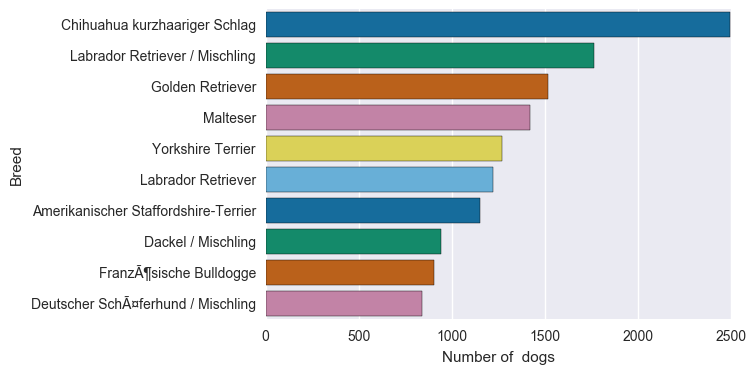

In [37]:
# Filter, sort and trim pandas Series
top_dogs = breeds[(breeds.index!='Unbekannt')].sort_values(ascending=False)[:10]
# Plot pandas Series
ax = sns.barplot(palette='colorblind', x=top_dogs.values, y=list(top_dogs.index))
ax.set(ylabel='Breed', xlabel='Number of  dogs')

Indeed, it seems that Chihuahuas (~2,500) and Labradors (~1,770) are the top pets among Viennese people. 

Wiener dog (Dackel) reaches only to position #8 in our Viennese dogs ranking. Sad... :(

##### Dogs per District
Now let's do the same trick but on the level of districts instead of breeds. Instead we want to aggregate dogs of all breeds for each of the districts of Vienna separately.

[<matplotlib.text.Text at 0x118ba9f90>, <matplotlib.text.Text at 0x11b47b390>]

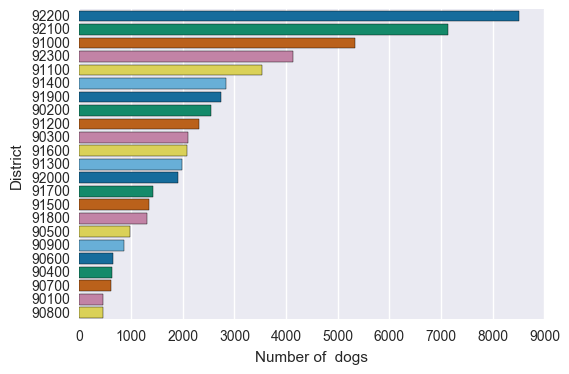

In [40]:
district_dogs = data.groupby('DISTRICT_CODE')['Anzahl'].aggregate(np.sum)
# Filter, sort and trim pandas Series
top_dogs = district_dogs.sort_values(ascending=False)
# Plot pandas Series
ax = sns.barplot(palette='colorblind', y=list(top_dogs.index), x=top_dogs.values, orient='h', order=list(top_dogs.index))
ax.set(ylabel='District', xlabel='Number of  dogs')

OK. 22nd and 21st district of Vienna are the most rich in dogs (8,5 and 7 thousands respectively). 10th, 23rd and 11th districts follow in the dog ranking. 

You are least likely to meet a dog, when visiting 1st and 8th districts of Vienna.

What could be the possible reasons for such variation in the number of dogs in different districts of Vienna (500-8,500 dogs per district)? We shall need more data to analyse these trends...

### Get More Data
Districts of any city (town) are not homogeneous in terms of area and population. Also in Vienna some districts are bigger in terms of territory, more densely populated or wealthier than other district. These factors shall also have an effect on the dog population within the specified regions. 

Now we need to fetch this kind of data (population, area and average income per district in Vienna) in order to check its correlation with our dog stats data. https://www.data.gv.at is the biggest Austrian open data portal. Let's have a look there! 

#### Population Statistics per District
Population (Bevölkerung) seems just right for the general category, filtering on Vienna, CSV data format and community districts (Gemeindebezirke) boils down the search results to a single dataset!

Next, we just repeat the same steps we used previously to obtain the dog data:

In [4]:
# Load the csv file from the open data portal
# Dataset description: https://www.data.gv.at/katalog/dataset/stadt-wien_viebevlkerungseit1869wien/resource/c9e9d0cc-8f71-4521-b598-17d71fab2f59
data_path = 'https://www.wien.gv.at/statistik/ogd/vie_101.csv'
# Look up the row file and specify the dataset format, e.g. delimiters
data_population = pd.read_csv(data_path, delimiter=';', skiprows=1)
# Check the top of the table to make sure the dataset is loaded correctly 
data_population.head()

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,POP_TOTAL,POP_MEN,POP_WOMEN,REF_DATE
0,AT1,AT13,AT130,90100,.,68079,.,.,18691231
1,AT1,AT13,AT130,90200,.,68442,.,.,18691231
2,AT1,AT13,AT130,90300,.,88678,.,.,18691231
3,AT1,AT13,AT130,90400,.,55682,.,.,18691231
4,AT1,AT13,AT130,90500,.,54010,.,.,18691231


We would prefer the most recent population data to be able to compare with the dog stats from 2016 12 01. 

It is not clear from the description of the dataset which time periods are covered either:
"VIE-Bevölkerung in den 23 Wiener Gemeindebezirken nach Geschlecht seit 1869
    Zuletzt aktualisiert	31. März 2016
    Erstellt	31. März 2016"

In [184]:
# Check unique column values
data_population['REF_DATE'].unique()

array([18691231, 18801231, 19001231, 19101231, 19230307, 19340322,
       19390517, 19510601, 19610321, 19710512, 19810512, 19910515,
       20010515, 20020101, 20030101, 20040101, 20050101, 20060101,
       20070101, 20080101, 20090101, 20100101, 20110101, 20120101,
       20130101, 20140101, 20150101])

The last measurement is from 2015 (same as on Wikipedia: https://de.wikipedia.org/wiki/Wiener_Gemeindebezirke#cite_note-11). Let's take it.

In [78]:
# Slice dataset: filter specific rows and columns
population_2015 = data_population[(data_population['REF_DATE'] == 20150101)][['DISTRICT_CODE', 'POP_TOTAL']]
# Sort column
population_2015.sort_values(ascending=False, by='POP_TOTAL').head()

,DISTRICT_CODE,POP_TOTAL
630,91000,189713
642,92200,172978
641,92100,151844
622,90200,101702
636,91600,100738


Very good we have the population count per district. Let's compare it with the dog counts. For this we need to join the datasets on the common column, which is the DISTRICT_CODE.

In [106]:
# Join Data Frame and Series objects on the key column
dog_vs_people = population_2015.join(top_dogs, on='DISTRICT_CODE')
dog_vs_people.sort_values(ascending=False, by='POP_TOTAL').head()

,DISTRICT_CODE,POP_TOTAL,Anzahl
630,91000,189713,5333
642,92200,172978,8504
641,92100,151844,7143
622,90200,101702,2545
636,91600,100738,2077


In [107]:
dog_vs_people['Dogs_per_person'] = dog_vs_people.Anzahl / dog_vs_people.POP_TOTAL
# Sort by column
dog_vs_people.sort_values(ascending=False, by='Dogs_per_person').round(3).head()

,DISTRICT_CODE,POP_TOTAL,Anzahl,Dogs_per_person
642,92200,172978,8504,0.049
641,92100,151844,7143,0.047
643,92300,96775,4136,0.043
639,91900,69999,2745,0.039
633,91300,52115,1990,0.038


22nd and 21st districts have the biggest dog populations relative to the number of inhabitants in the district: 49 and 47 dogs per 1000 people respectively.

These districts are also the largest in terms of territory. Let's get this data into play as well!

#### Area Statistics per District
Getting back to https://www.data.gv.at. Ok this one was not easy to find!
TODO

#### Income Statistics per District
This dataset was relatively easy to find when searching with the keyword 'income' (einkommen) on https://www.data.gv.at portal.

In [83]:
# Load the csv file from the open data portal
# Dataset description: https://www.data.gv.at/katalog/dataset/stadt-wien_viewirtschaftwienergemeindebezirke1/resource/c1ad52a3-ca5c-44fc-a945-b6459f73ed98
data_path = 'https://www.wien.gv.at/statistik/ogd/vie_502.csv'
# The data format seems to be consistent for all the datasets from this publisher 
data_income = pd.read_csv(data_path, delimiter=';', skiprows=1)
# Check the top of the table to make sure the dataset is loaded correctly 
data_income.head()

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,INCOME_TOTAL,INCOME_MEN,INCOME_WOMEN,AVERAGE_INCOME_TOTAL,AVERAGE_INCOME_MEN,AVERAGE_INCOME_WOMEN,AVERAGE_INCOME_FULLTIME_TOTAL,AVERAGE_INCOME_FULLTIME_MEN,AVERAGE_INCOME_FULLTIME_WOMEN,REF_DATE
0,AT1,AT13,AT130,90100,.,292.103.000,194.301.000,97.802.000,25.463,31.961,18.536,34.506,42.806,24.963,20021231
1,AT1,AT13,AT130,90200,.,919.962.000,559.682.000,360.280.000,16.439,18.301,14.282,22.015,24.312,19.067,20021231
2,AT1,AT13,AT130,90300,.,1.011.882.000,608.994.000,402.888.000,18.701,21.444,15.804,24.617,27.968,20.739,20021231
3,AT1,AT13,AT130,90400,.,402.479.000,243.807.000,158.672.000,20.325,23.641,16.876,27.348,31.586,22.539,20021231
4,AT1,AT13,AT130,90500,.,554.361.000,327.128.000,227.233.000,16.258,17.937,14.395,22.059,24.198,19.454,20021231


In [87]:
# Check unique column values
data_income['REF_DATE'].unique()

array([20021231, 20031231, 20041231, 20051231, 20061231, 20071231,
       20081231, 20091231, 20101231, 20111231, 20121231, 20131231, 20141231])

The last measurement is from 2014. Let's take it.

In [91]:
# Slice dataset: filter specific rows and columns
income_2014 = data_income[(data_income['REF_DATE'] == 20141231)][['DISTRICT_CODE', 'AVERAGE_INCOME_TOTAL']]
# Sort column
income_2014.sort_values(ascending=False, by='AVERAGE_INCOME_TOTAL').head()

,DISTRICT_CODE,AVERAGE_INCOME_TOTAL
276,90100,32.493
288,91300,27.604
294,91900,25.803
279,90400,24.199
293,91800,24.164


All right this is common knowledge ;)

[<matplotlib.text.Text at 0x11bdc8cd0>, <matplotlib.text.Text at 0x11d6c9fd0>]

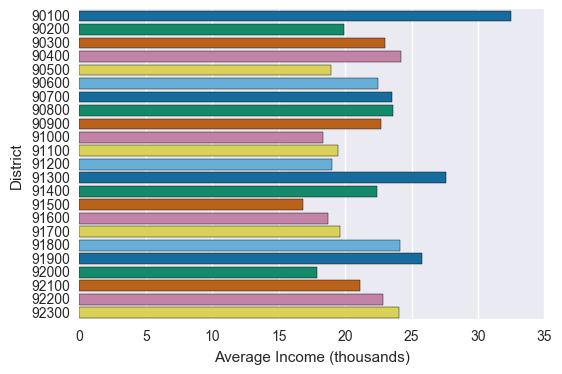

In [100]:
# Plot pandas data frame
ax = sns.barplot(data=income_2014,palette='colorblind', y='DISTRICT_CODE', x='AVERAGE_INCOME_TOTAL', orient='h')
ax.set(ylabel='District', xlabel='Average Income (thousands)')

Let's join our data sets with district stats.

In [118]:
# Merge data frames on the key column
dog_vs_people_vs_income = dog_vs_people.merge(income_2014, on='DISTRICT_CODE')
dog_vs_people_vs_income.sort_values(ascending=False, by='AVERAGE_INCOME_TOTAL').head()

,DISTRICT_CODE,POP_TOTAL,Anzahl,Dogs_per_person,AVERAGE_INCOME_TOTAL
0,90100,16339,465,0.028460,32.493
12,91300,52115,1990,0.038185,27.604
18,91900,69999,2745,0.039215,25.803
3,90400,31691,632,0.019943,24.199
17,91800,49178,1316,0.026760,24.164


#### Hundezonen in Wien
TODO
https://www.wien.gv.at/umwelt/parks/hundezonen.html
https://www.wien.gv.at/statistik/lebensraum/tabellen/hundezonen-bez.html

### Open Data for Local Communities

In [132]:
# analyse district stats
district = 1190
dogs_district = data[(data['Dog Breed']!='Unbekannt')][(data['Postal_CODE']==district)][['Dog Breed', 'Anzahl']]
top_dogs_district = dogs_district.sort_values(ascending=False, by='Anzahl')[:10]
top_dogs_district

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,Dog Breed,Anzahl
4127,Labrador Retriever / Mischling,102
4073,Golden Retriever,96
4118,Labrador Retriever,81
4023,Chihuahua kurzhaariger Schlag,77
4142,Malteser,57
4236,Yorkshire Terrier,46
4045,Deutscher SchÃ¤ferhund,44
4039,Dackel / Mischling,39
4104,Jack-Russell-Terrier / Mischling,35
4149,Mops,35


[<matplotlib.text.Text at 0x123b89cd0>, <matplotlib.text.Text at 0x123b79410>]

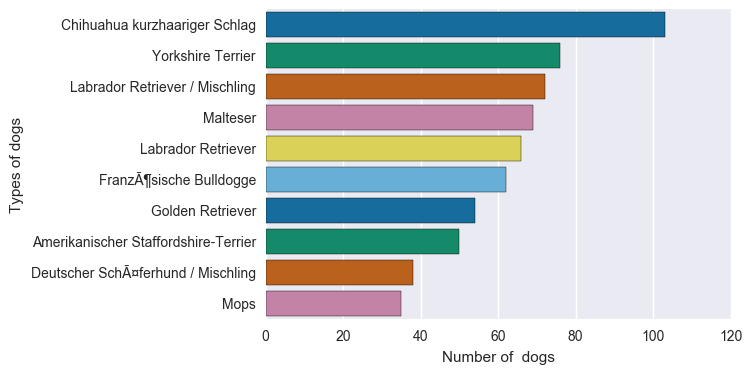

In [119]:
ax = sns.barplot(data=top_dogs_1020,palette='colorblind', x='Anzahl', y='Dog Breed')
ax.set(ylabel='Types of dogs', xlabel='Number of  dogs')

## Lessons Learned
* Open Data Quality
    1. Descriptions
    2. Formatting
* Dogs in Vienna
    1. Based on the data available